In [2]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from dask.distributed import wait
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

## Spin up DASK cluster

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(20) 
client

Client Scheduler: tcp://128.117.208.70:45715 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
varname='IFRAC'
varnames=[varname]

In [6]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ocn',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict()
            
        ds = dsets[f'ocn.{experiment}.pop.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bound.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['z_t','time_bound','z_t_150m','KMT','TLAT','TLONG','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [7]:
import utils

In [8]:
## Enter the years you want to keep:
yy_st = "1850"
yy_ed = "2100"

In [9]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -50

## Load CESM2-LE data

### Load the Data Catalog

In [10]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [11]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
# preprocess if some variables need depth averaging
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 22 s, sys: 437 ms, total: 22.5 s
Wall time: 32.2 s


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 55, nlon: 320, time: 1980, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
  * time        (time) object 1850-01-16 13:00:00.000001 ... 2014-12-16 12:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 55, 320), meta=np.ndarray>
    IFRAC       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 55, 320), meta=np.ndarray>

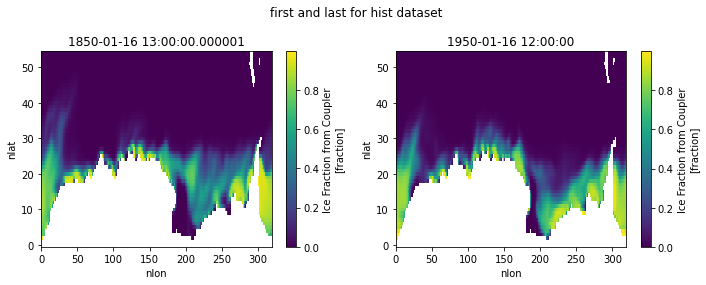

In [12]:
mem_5_hist = ds_hist[varnames[0]].isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [13]:
%%time
# load historical
ds_ssp = load_datasets(varnames,'ssp370',lat_min,lat_max)
# preprocess if some variables need depth averaging
#ds_ssp = preprocess(ds_ssp)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 10.9 s, sys: 161 ms, total: 11.1 s
Wall time: 14.9 s


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 55, nlon: 320, time: 1032, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
  * time        (time) object 2015-01-16 13:00:00.000001 ... 2100-12-16 12:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(55, 320), meta=np.ndarray>
    time_bound  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 55, 320), meta=np.ndarray>
    IFRAC       (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 55, 320), meta=np.ndarray>

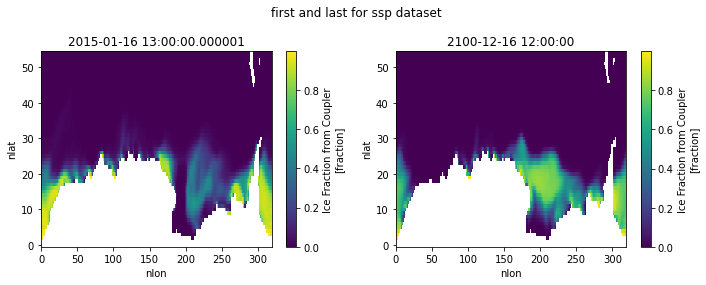

In [14]:
mem_5_ssp = ds_ssp[varnames[0]].isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last for ssp dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets, keep just years of interest

In [15]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 13, 0, 0, 1),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16 12:00:00

In [16]:
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 13, 0, 0, 1),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2100-12-16 12:00:00

In [17]:
# Dataset will become shorter because of the Jan.1 boundary for some seasons
# for 1950-2100, 150 years long (1800 time steps instead of 1812). Last year will be 2099
years = np.arange(int(yy_st),int(yy_ed)+1,1)

tlen = 251 #annual timesteps 
xlen = len(ds.nlon)
ylen = len(ds.nlat)
elen = len(ds.member_id)
print(tlen,xlen,ylen,elen)

251 320 55 50


In [18]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

### Read in preprocessed data from other file

In [19]:
#file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-means-IFRAC_v2.nc'
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-seasonal-means-IFRAC-hi_v4.nc'

ds_ice = xr.open_dataset(file)
#ds_ice = ds_ice.isel(time=slice(70,250))
ds_ice

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 250)
Coordinates:
  * time          (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 ...
    SIT_OND       (time, member_id, nlat, nlon) float64 ...
    SIT_JFM       (time, member_id, nlat, nlon) float64 ...
    SIT_AMJ       (time, member_id, nlat, nlon) float64 ...
    SIT_JAS       (time, member_id, nlat, nlon) float64 ...
    SIT_ONDJFM    (time, member_id, nlat, nlon) float64 ...
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-03-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

# Compute Seasonal Means
* Growing season = ONDJFM 
* Early Season = OND
* Late Season = JFM
* Ice advance season = AMJ


### add ice advance season to dataset (AMJ)

In [19]:
%%time

var = 'IFRAC'

ds_AMJ_int = xr.Dataset()

AMJ_int = np.zeros([tlen-1,elen,ylen,xlen])

for year in np.arange(0,250,1):
    print(year)
    #get april for this year
    st_mon = year*12 + 3

    #sum over oct to following year march
    i=0
    for month in [4,5,6]:

        if(month == 4):
            summing = ds[var].isel(time=st_mon) * days_per_month[month-1]
            tot_days = days_per_month[month-1]
        else:
            summing = summing + ds[var].isel(time=st_mon+i) * days_per_month[month-1]
            tot_days = tot_days + days_per_month[month-1]
        i = i + 1

    AMJ_int[year,:,:,:] = (summing/tot_days).compute()

AMJ_int = xr.DataArray(AMJ_int,dims=('time','member_id','nlat','nlon'))

ds_AMJ_int[var] = AMJ_int

ds_AMJ_int[var].attrs['units'] = 'fraction'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
CPU times: user 1min 28s, sys: 4.68 s, total: 1min 32s
Wall time: 3min 56s


In [23]:
ds_AMJ_int['time'] = np.arange(1850,2100,1)
ds_AMJ_int

<xarray.Dataset>
Dimensions:  (member_id: 50, nlat: 55, nlon: 320, time: 250)
Coordinates:
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC    (time, member_id, nlat, nlon) float64 nan nan nan ... 0.0 0.0 0.0

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon) Include TLAT and TLONG as coordinates
- One netcdf per variable per time period: ONDJFM (whole growing season), OND (early), JFM (late)

In [25]:
ds_out = ds_ice

ds_out['IFRAC_AMJ'] = ds_AMJ_int['IFRAC']

ds_out.attrs['author'] = 'Kristen Krumhardt'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly ifrac in the Southern Ocean from 1850 to 2099. Each variable represents mean ice fraction for specific seasons: ONDJFM (whole growing season), OND (early), JFM (late)'

ds_out

<xarray.Dataset>
Dimensions:       (member_id: 50, nlat: 55, nlon: 320, time: 250)
Coordinates:
  * time          (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id, nlat, nlon
Data variables:
    IFRAC_ONDJFM  (time, member_id, nlat, nlon) float64 ...
    IFRAC_OND     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JFM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_JAS     (time, member_id, nlat, nlon) float64 ...
    IFRAC_SON     (time, member_id, nlat, nlon) float64 ...
    IFRAC_MAM     (time, member_id, nlat, nlon) float64 ...
    IFRAC_AMJ     (time, member_id, nlat, nlon) float64 nan nan nan ... 0.0 0.0
Attributes:
    author:          Kristen Krumhardt
    date_processed:  2025-01-03
    contents:        yearly ifrac in the Southern Ocean from 1850 to 2099. Ea...

In [26]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	member_id: (50,)
	nlat: (55,)
	nlon: (320,)
	time: (250,)
Coordinates:
	time:
		[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028

## Export and Save

In [27]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 11.47 GB.


In [29]:
path_out = '/glade/derecho/scratch/kristenk/ToE_saved_data/'
file_out = 'CESM2-LE-seasonal-means-IFRAC_v3.nc'
fout = path_out + file_out

In [30]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [31]:
cluster.close()

## Test if it worked

In [32]:
path =  path_out
ds_test =  xr.open_dataset(path_out+file_out, decode_times=True)

In [33]:
ds_test.info()

xarray.Dataset {
dimensions:
	member_id = 50 ;
	nlat = 55 ;
	nlon = 320 ;
	time = 250 ;

variables:
	int64 time(time) ;
	float64 IFRAC_ONDJFM(time, member_id, nlat, nlon) ;
		IFRAC_ONDJFM:units = fraction ;
	float64 IFRAC_OND(time, member_id, nlat, nlon) ;
		IFRAC_OND:units = fraction ;
	float64 IFRAC_JFM(time, member_id, nlat, nlon) ;
		IFRAC_JFM:units = fraction ;
	float64 IFRAC_JAS(time, member_id, nlat, nlon) ;
		IFRAC_JAS:units = fraction ;
	float64 IFRAC_SON(time, member_id, nlat, nlon) ;
		IFRAC_SON:units = fraction ;
	float64 IFRAC_MAM(time, member_id, nlat, nlon) ;
		IFRAC_MAM:units = fraction ;
	float64 IFRAC_AMJ(time, member_id, nlat, nlon) ;
		IFRAC_AMJ:units = fraction ;

// global attributes:
	:author = Kristen Krumhardt ;
	:date_processed = 2025-01-03 ;
	:contents = yearly ifrac in the Southern Ocean from 1850 to 2099. Each variable represents mean ice fraction for specific seasons: ONDJFM (whole growing season), OND (early), JFM (late) ;
}

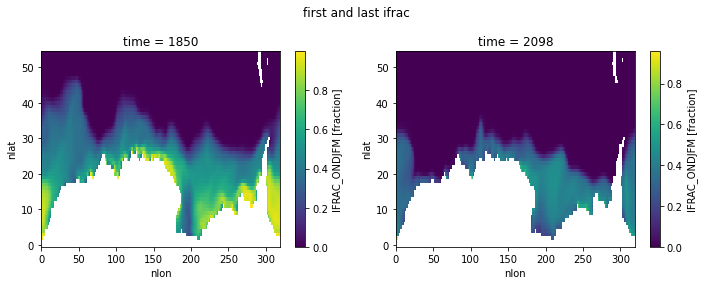

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [34]:
mem_5_ints = ds_test.IFRAC_ONDJFM.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)
# ax1.set_title(mem_5_ints.isel(time=0).time.values)

mem_5_ints.isel(time=-2).plot(ax=ax2)
#ax2.set_title(mem_5_ints.isel(time=-1).time.values)

fig.suptitle("first and last ifrac")

plt.tight_layout()
plt.show()